In [12]:
import os

from descartes.patch import PolygonPatch
import joblib
import geopandas as gpd
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [13]:
d6_bbls = np.load("data/bimg_labels_d6.npy")
d9_bbls = np.load("data/bimg_labels_d9.npy")
pluto = gpd.read_file("data/pluto/MNMapPLUTO.shp")
pluto["surface_area"] = pluto["NumFloors"] * pluto.geometry.length
in_frame = pluto[(pluto.BBL.isin(np.unique(d6_bbls.ravel()))) | pluto.BBL.isin(np.unique(d9_bbls.ravel()))]
out_frame = pluto[(pluto.geometry.centroid.y < 215000) & ~pluto.index.isin(in_frame.index)]

final_light_d6 = pd.read_csv("data/bbl_2017-09-28/2017-09-28_d6_10m.csv")
final_light_d9 = pd.read_csv("data/bbl_2017-09-28/2017-09-28_d9_10m.csv")
for df in (final_light_d6, final_light_d9):
    del df["Unnamed: 0"]
    del df["lat"]
    del df["lng"]
final_light_d6 = final_light_d6.set_index("BBL").swapaxes(1, 0)
final_light_d9 = final_light_d9.set_index("BBL").swapaxes(1, 0)

In [14]:
concatd = pd.concat((final_light_d6, final_light_d9))
final_light = concatd.groupby(concatd.index).mean()


In [15]:
if os.path.exists("data/impute_dists_centroid.gz"):
    dists = joblib.load("data/impute_dists_centroid.gz")
    nearest_idxs = joblib.load("data/impute_idxs_centroid.gz")
else:
    dists = []
    nearest_idxs = []
    for ix, building in out_frame.iterrows():
        if ix % 1000 == 0:
            print("at", ix)
        ds = in_frame.geometry.centroid.distance(building.geometry.centroid)
        dists.append(ds.min())
        nearest_idxs.append(ds.idxmin())
    joblib.dump(dists, "data/impute_dists_centroid.gz", 3)
    joblib.dump(nearest_idxs, "data/impute_idxs_centroid.gz", 3)
    
dists_arr = np.array(dists)

out_reset = out_frame.reset_index()
out_reset["dist"] = dists_arr


In [44]:
import string
RESIDENTIAL = set("ABCDHLNRS")
COMMERCIAL = set(string.ascii_uppercase) - RESIDENTIAL
print(" residential: ", RESIDENTIAL,"\n", "commercial: ", COMMERCIAL)

ind = in_frame.dropna(subset=["BldgClass"])
in_residential = ind[ind.BldgClass.str[0].isin(RESIDENTIAL)]
in_commercial = in_frame[~in_frame.index.isin(in_residential.index)]
print(" residential: ", len(in_residential))
print(" commercial: ", len(in_commercial))
print(" ratio:", len(in_residential) / len(in_frame))
print(" total: ", len(in_frame))

 residential:  {'N', 'S', 'L', 'C', 'D', 'R', 'H', 'A', 'B'} 
 commercial:  {'M', 'O', 'U', 'Y', 'J', 'P', 'E', 'I', 'Z', 'K', 'G', 'X', 'F', 'V', 'T', 'Q', 'W'}
 residential:  2479
 commercial:  909
 ratio: 0.7317001180637545
 total:  3388


In [45]:
nearest_neighbors = []
res_count = 0
for ix, of in out_frame.iterrows():
    osa = of.surface_area
    if (of.BldgClass and of.BldgClass[0] in RESIDENTIAL):
        areas = in_residential 
        res_count += 1
    else:
        areas = in_commercial
    nearest_neighbors.append(np.abs(areas.surface_area - osa).sort_values()[:10].index)
    

out_reset["nearest_ix"] = nearest_neighbors
res_count, len(out_frame), res_count / len(out_frame)

(9628, 13621, 0.7068497173482123)

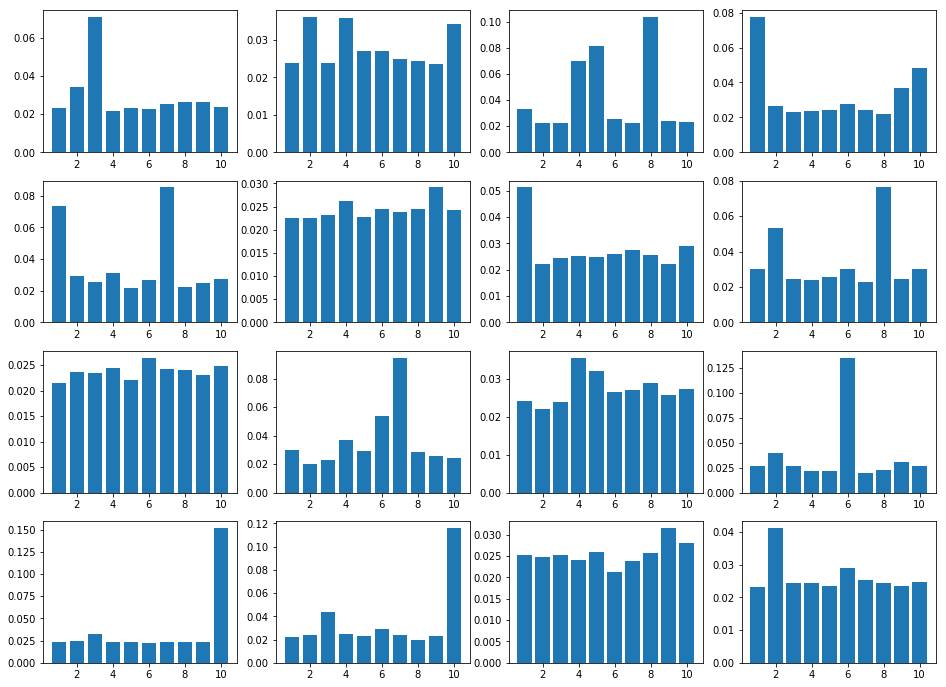

In [22]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()
for ax, indices in zip(axes, out_reset["nearest_ix"].sample(frac=1)):

    cbbl = in_frame.loc[indices].BBL
    means = [final_light_d6[c].mean() if c in final_light_d6 else final_light_d9[c].mean() for c in cbbl]
    ax.bar(range(1, 11), means)

In [23]:
ranges = []
for indices in out_reset["nearest_ix"]:
    cbbl = in_frame.loc[indices].BBL
    means = final_light[list(cbbl)].mean()
    ranges.append(means.max() - means.min())

#### Below is a histogram of log(max(mean(brightnesses)) - min(mean(brightnesses))) for brightnesses of 10nn of each out-of-frame BBL

(array([ 237., 1255., 2338., 2507., 2687., 2166.,  805., 1511.,   59.,
          56.]),
 array([-6.0225223 , -5.4225206 , -4.8225189 , -4.22251721, -3.62251551,
        -3.02251381, -2.42251211, -1.82251041, -1.22250872, -0.62250702,
        -0.02250532]),
 <a list of 10 Patch objects>)

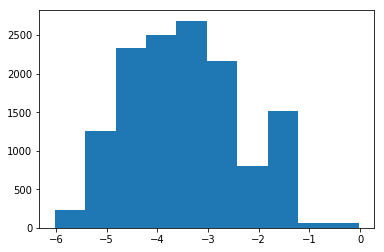

In [24]:
plt.hist(np.log(ranges))

In [25]:
values = []
for indices in out_reset["nearest_ix"]:
    cbbl = in_frame.loc[indices].BBL
    results = final_light[list(cbbl)]
    for ix, result in results.iterrows():
        values.append((ix, result.max() - result.min()))
        
vals = np.array(values)
vals_df = pd.DataFrame({"diff": vals[:, 1].astype(np.float64)}, index=vals[:, 0].astype(np.datetime64))


Text(0.5,1,'Average diff of 10nn over time')

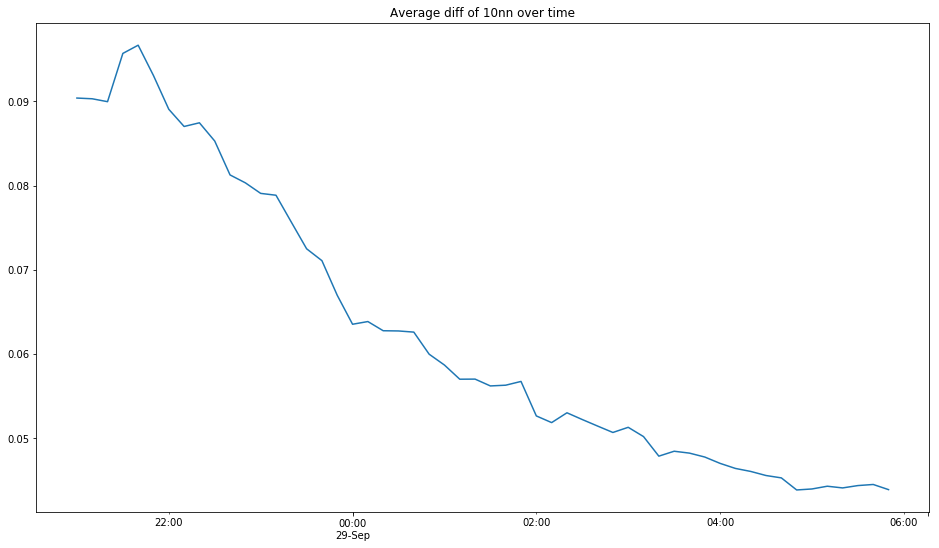

In [26]:
means = vals_df.groupby(vals_df.index)['diff'].mean()
ax = means.plot(figsize=(16, 9))
ax.set_title("Average diff of 10nn over time")

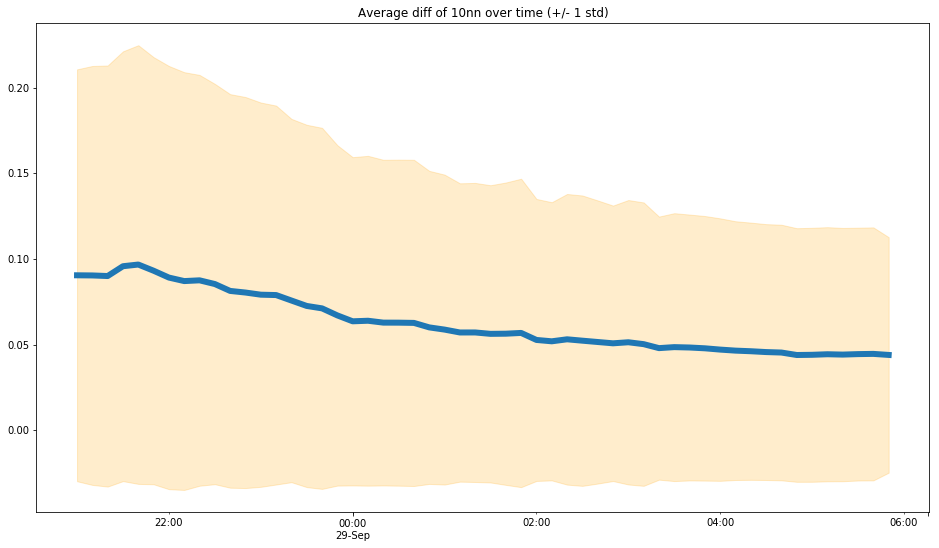

In [27]:
stds = vals_df.groupby(vals_df.index)['diff'].std()
ax = means.plot(figsize=(16, 9), linewidth=6)
ax.set_title("Average diff of 10nn over time (+/- 1 std)")
ax.fill_between(means.index, means + stds, means - stds, color='orange', alpha=.2)

Text(0.5,1,'histogram of log(max(brightnesses) - min(brightnesses)) at one time slice')

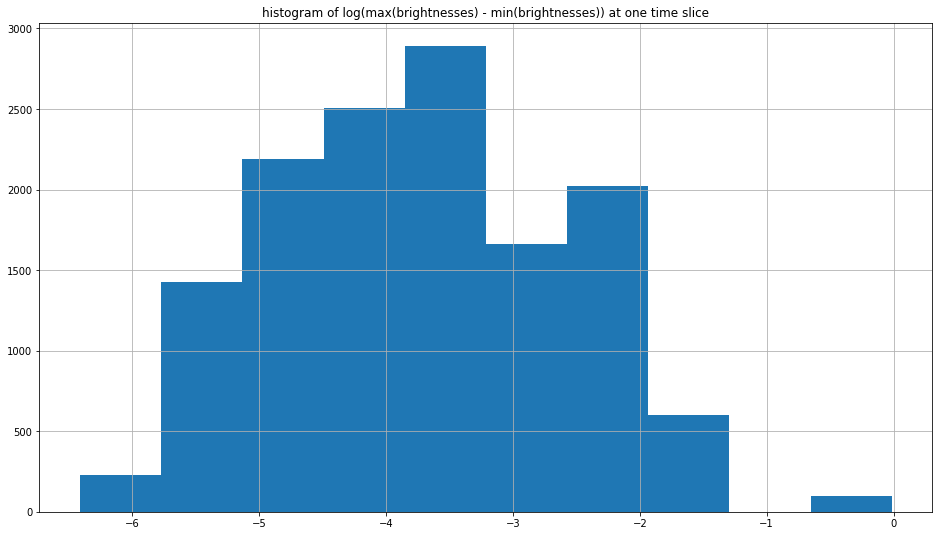

In [28]:
ax = np.log(vals_df.groupby(vals_df.index).get_group(vals_df.index[100])["diff"]).hist(figsize=(16, 9))
ax.set_title("histogram of log(max(brightnesses) - min(brightnesses)) at one time slice")

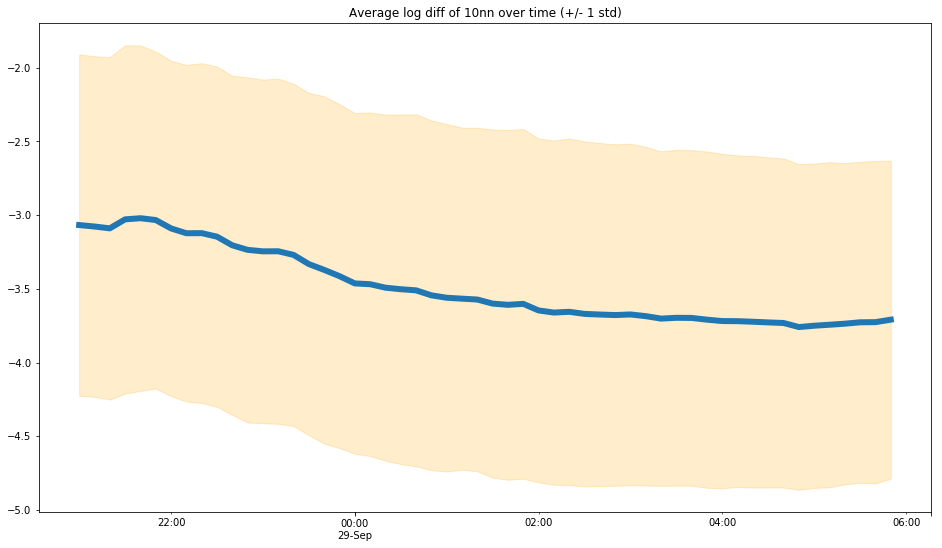

In [29]:
means = np.log(vals_df).groupby(vals_df.index)['diff'].mean()
stds = np.log(vals_df).groupby(vals_df.index)['diff'].std()
ax = means.plot(figsize=(16, 9), linewidth=6)
ax.set_title("Average log diff of 10nn over time (+/- 1 std)")
ax.fill_between(means.index, means + stds, means - stds, color='orange', alpha=.2)

Text(0.5,1,'mean BBL brightness for 2017-09-28, imputing from mean of 10nn')

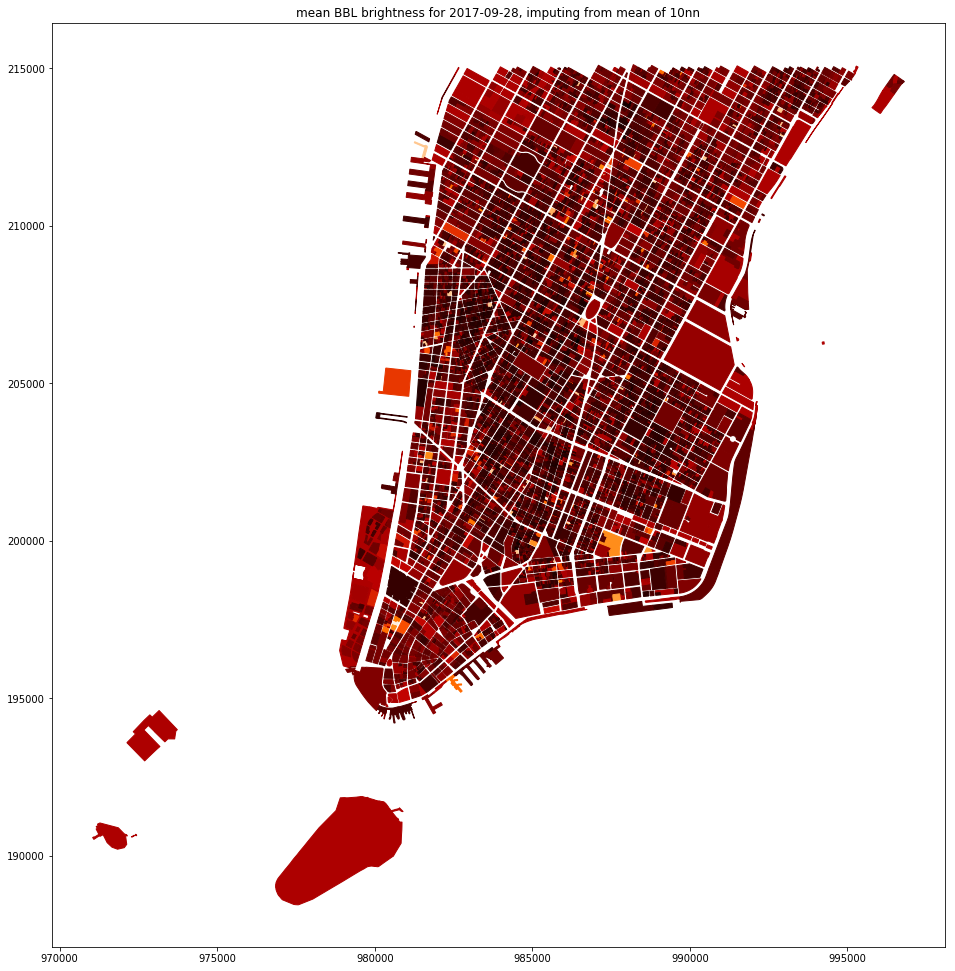

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))

polys = []
colors = []
scale = np.log10(final_light.mean()).min()
for _, o_r in out_reset.iterrows():
    cbbl = in_frame.loc[o_r.nearest_ix].BBL
    c = final_light[list(cbbl)].mean().mean()
    polys.append(PolygonPatch(o_r.geometry))
    colors.append(plt.cm.gist_heat((np.log10(c) - scale)))
for _, i_r in in_frame.iterrows():
    c = final_light[i_r.BBL].mean()
    polys.append(PolygonPatch(i_r.geometry))
    colors.append(plt.cm.gist_heat((np.log10(c) - scale)))

collection = PatchCollection(polys, color=colors)
ax.add_collection(collection)
ax.autoscale_view()
ax.set_aspect(1)
ax.set_title("mean BBL brightness for 2017-09-28, imputing from mean of 10nn")

## Now, do 100

In [37]:
nearest_neighbors_100 = []
for ix, of in out_frame.iterrows():
    osa = of.surface_area
    areas = in_residential if (of.BldgClass and of.BldgClass[0] in RESIDENTIAL) else in_commercial
    nearest_neighbors_100.append(np.abs(areas.surface_area - osa).sort_values()[:100].index)
    

out_reset["nearest_ix_100"] = nearest_neighbors_100

Text(0.5,1,'mean BBL brightness for 2017-09-28, imputing from mean of 100nn')

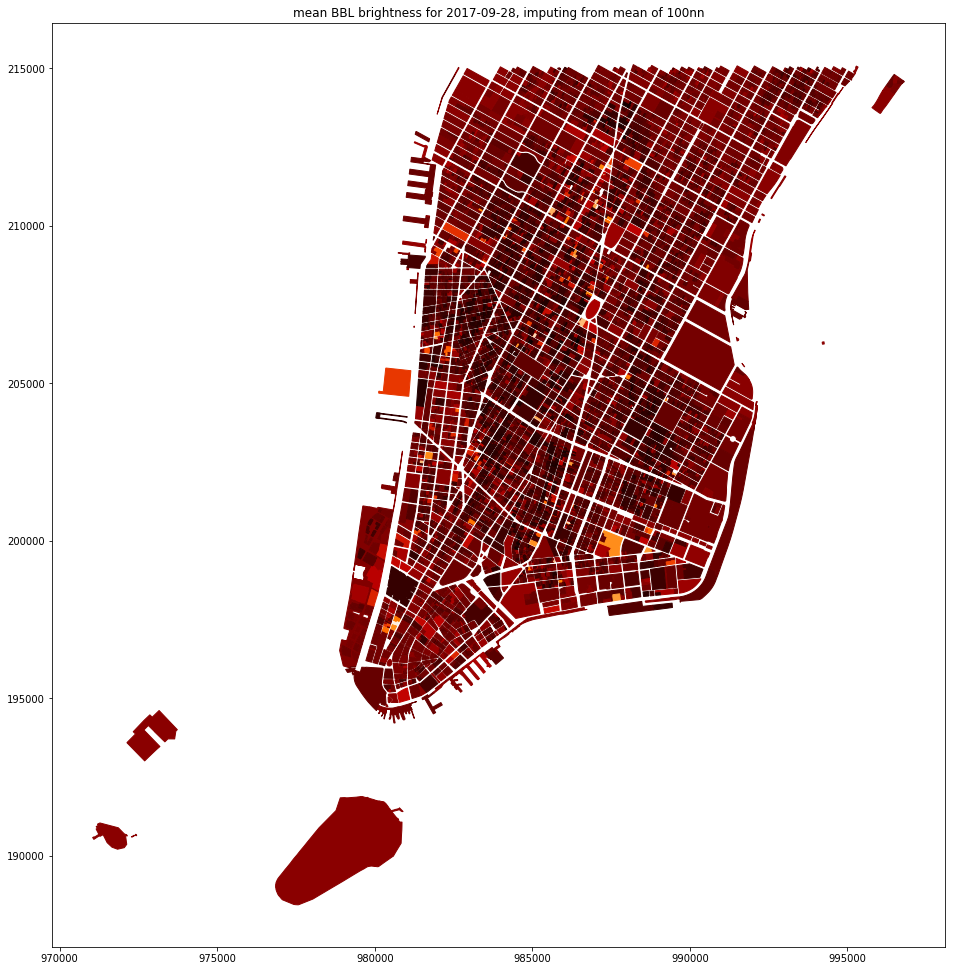

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))

polys = []
colors = []
scale = np.log10(final_light.mean()).min()
for _, o_r in out_reset.iterrows():
    cbbl = in_frame.loc[o_r.nearest_ix_100].BBL
    c = final_light[list(cbbl)].mean().mean()
    polys.append(PolygonPatch(o_r.geometry))
    colors.append(plt.cm.gist_heat((np.log10(c) - scale)))
for _, i_r in in_frame.iterrows():
    c = final_light[i_r.BBL].mean()
    polys.append(PolygonPatch(i_r.geometry))
    colors.append(plt.cm.gist_heat((np.log10(c) - scale)))

collection = PatchCollection(polys, color=colors)
ax.add_collection(collection)
ax.autoscale_view()
ax.set_aspect(1)
ax.set_title("mean BBL brightness for 2017-09-28, imputing from mean of 100nn")

In [39]:
ranges = []
for indices in out_reset["nearest_ix_100"]:
    cbbl = in_frame.loc[indices].BBL
    means = final_light[list(cbbl)].mean()
    ranges.append(means.max() - means.min())


#### Below is a histogram of log(max(mean(brightnesses)) - min(mean(brightnesses))) for brightnesses of 100nn of each out-of-frame BBL

(array([ 948.,  973., 1860., 1618., 2099., 4647.,  176.,  284.,  617.,
         399.]),
 array([-3.49048567, -3.14354983, -2.79661399, -2.44967816, -2.10274232,
        -1.75580648, -1.40887064, -1.0619348 , -0.71499896, -0.36806313,
        -0.02112729]),
 <a list of 10 Patch objects>)

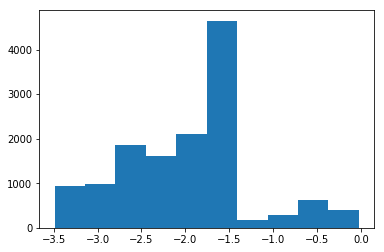

In [40]:
plt.hist(np.log(ranges))